In [1]:
import pandas as pd
import numpy as np
from time import time
from data.data import load_data
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

Using TensorFlow backend.


In [2]:
# TODO fill this cell out

# Give this run a title
run = 'capsnet_15+capsnet_bn+nasnet_15+recnn_15_aug_klaus'
#run = 'capsnet_15+capsnet_bn+convnet_15+nasnet_15+recnn_15_aug'

# Add validation files
capsnet_val = pd.read_csv('./ensemble/validation_capsnet_15epoch_aug.csv')
capsnet_bn_val = pd.read_csv('./ensemble/validation_capsnet_bn_15epochs.csv')
convnet_val = pd.read_csv('./ensemble/validation_convnet_augmentation.csv')
nasnet_val = pd.read_csv('./ensemble/validation_Nasnet_15epoch_aug.csv')
recnn_val = pd.read_csv('./ensemble/validation_recnn_15epoch_aug_regenerated.csv')
datas = [capsnet_val, capsnet_bn_val, convnet_val, nasnet_val, recnn_val]

# Add test files
capsnet_test = pd.read_csv('./ensemble/test_capsnet_15epoch_aug.csv')
capsnet_bn_test = pd.read_csv('./ensemble/test_capsnet_bn_15epochs.csv')
convnet_test = pd.read_csv('./ensemble/test_convnet_augmentation.csv')
nasnet_test = pd.read_csv('./ensemble/test_Nasnet_15epoch_aug.csv')
recnn_test = pd.read_csv('./ensemble/test_recnn_15epoch_augmentation.csv')
tests = [capsnet_test, capsnet_bn_test, convnet_test, nasnet_test, recnn_test]

In [3]:
# Create x and y datasets
x_total_train = np.stack(([x['prediction'] for x in datas]), axis=1)
_, (_, y_pred_val, _), _ = load_data()
y_total_train = np.ravel(y_pred_val)
x_train, x_valid, y_train, y_valid = train_test_split(x_total_train, y_total_train)

# Create x testset
x_test = np.stack(([x['prediction'] for x in tests]), axis=1)

In [4]:
# Correlation matrix on validation files
predictions = {'capsnet_val': capsnet_val['prediction'],
              'capsnet_bn_val': capsnet_bn_val['prediction'],
              'convnet_val': convnet_val['prediction'],
              'nasnet_val': nasnet_val['prediction'],
              'recnn_val': recnn_val['prediction']}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

,capsnet_val,capsnet_bn_val,convnet_val,nasnet_val,recnn_val
capsnet_val,1.000000,0.880357,0.244841,0.837443,0.867651
capsnet_bn_val,0.880357,1.000000,0.251747,0.833739,0.863396
convnet_val,0.244841,0.251747,1.000000,0.261952,0.268081
nasnet_val,0.837443,0.833739,0.261952,1.000000,0.869997
recnn_val,0.867651,0.863396,0.268081,0.869997,1.000000


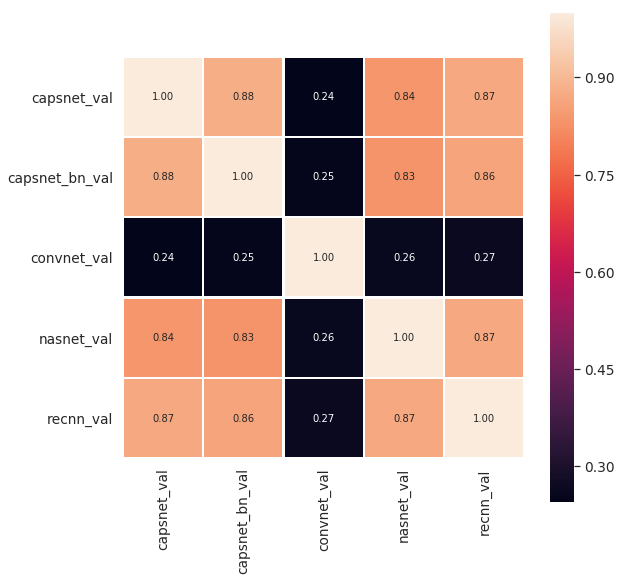

In [5]:
# Plot validation correlations
plt.figure(figsize=(9, 9))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.yticks(rotation=0)
plt.show()

In [6]:
# Correlation matrix on test files
predictions = {'capsnet_test': capsnet_test['prediction'],
              'capsnet_bn_test': capsnet_bn_test['prediction'],
              'convnet_test': convnet_test['prediction'],
              'nasnet_test': nasnet_test['prediction'],
              'recnn_test': recnn_test['prediction']}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

,capsnet_test,capsnet_bn_test,nasnet_test,recnn_test
capsnet_test,1.000000,0.854907,0.812903,0.844752
capsnet_bn_test,0.854907,1.000000,0.802340,0.831490
nasnet_test,0.812903,0.802340,1.000000,0.853192
recnn_test,0.844752,0.831490,0.853192,1.000000


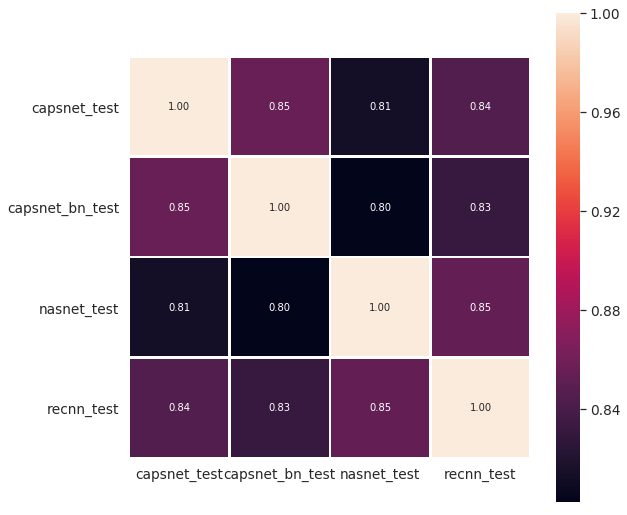

In [7]:
# Plot correlations
plt.figure(figsize=(9, 9))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.yticks(rotation=0)
plt.show()

In [12]:
# Parameter tuning
xg_model = XGBClassifier(n_estimators=100, seed = 1234)
param_dict = {'max_depth': [1,2,3,4],
              'min_child_weight': [1,2,3],
              'learning_rate': [00.1,0.15,0.2],
              'gamma': [0, 0.1, 0.2]
}

start = time()
grid_search = GridSearchCV(xg_model, param_dict, cv=5, verbose=10, n_jobs=16)
grid_search.fit(x_train, y_train)
print("GridSearch took %.2f seconds to complete." % (time()-start))
display(grid_search.best_params_)
best = grid_search.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.6s


KeyboardInterrupt: 

In [13]:
# Fitting the model
xg_model = XGBClassifier(n_estimators = 1000,
                        learning_rate = best['learning_rate'],
                        max_depth = best['max_depth'],
                        min_child_weight = best['min_child_weight'],
                        gamma = best['gamma'],
                        seed = 1234)
start = time()
xg_model.fit(x_train, y_train)
xg_preds = xg_model.predict(x_valid)
print("Model took %.2f seconds to complete." % (time()-start))
print("Validation accuracy: %.4f" % accuracy_score(y_valid, xg_preds))

Model took 40.29 seconds to complete.
Validation accuracy: 0.9215


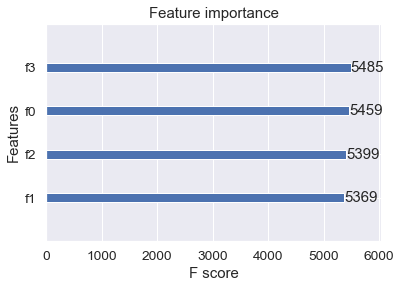

In [73]:
# Most important features (models)
plot_importance(xg_model)
plt.show()
#[capsnet_val, capsnet_bn_val, nasnet_val, recnn_val]

In [74]:
# Train on whole dataset
xg_model_total = XGBClassifier(n_estimators = 1000,
                        learning_rate = best['learning_rate'],
                        max_depth = best['max_depth'],
                        min_child_weight = best['min_child_weight'],
                        gamma = best['gamma'],
                        seed = 1234)
xg_model_total.fit(x_total_train, y_total_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.2,
       learning_rate=0.15, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
       silent=None, subsample=1, verbosity=1)

In [83]:
# Predict on model
xg_preds = xg_model_total.predict_proba(x_test)
data = {'case': np.arange(xg_preds.shape[0]), 'prediction': np.ravel(xg_preds[:,1])}
submission = pd.DataFrame(data=data)
submission.to_csv('./predictions/test_xgboost_{}.csv'.format(run), index=False)